In [133]:
import numpy as np
from scipy import special
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 14

# Calculation of vertical displacement due to loading

## Step1: Comparision with Argus et al. (201X)

$$ d = Gm $$

- d: data (displacement; $n_d\times1$)
- m: model (mass; $n_m\times1$)

In [134]:
def calc_deformation_disk(M, lamda, mu, alpha, r):
    ''' 
    Calculates the deformation for a disk of mass M and radius alpha, on top of a substrate with Lame parameter lambda and shear modulus mu.
    M: mass of the disk, kg
    lamda: Lame parameter of substrate
    mu: shear modulus of substrate
    alpha: disk radius, in metres
    r: array of distances from centre of disk at which to calculate solution. In metres. eg r = np.linspace(0,50*10**3,num=1000) to go to 50km distance.
    
    '''
    sigma=lamda+2*mu
    nabla=lamda + mu
    
    defm=np.zeros_like(r)
    
    r_disk = r[r<=alpha]
    r_postdisk = r[r>=alpha]
    
    defm[r<=alpha]=-M*g* (sigma/(np.pi**2 * mu * nabla * alpha) * special.ellipe((r_disk/alpha)**2) )  
    defm[r>=alpha]= -M *g* (sigma* r_postdisk / (np.pi**2 * mu * nabla * alpha**2)) * (special.ellipe((alpha/r_postdisk)**2) - (1 - (alpha/r_postdisk)**2) * special.ellipk((alpha/r_postdisk)**2)) 
    
    return defm

In [135]:
# These are the displacements which I picked by hand from Argus 2017
argus_traced_14_disp = -1*np.array([2.6, 2.3, 1.4, 0.7, 0.3, 0.15]) 
# And these are the corresponding distances in kilometres
argus_traced_14_distance = [0,9,16,20,36,50]

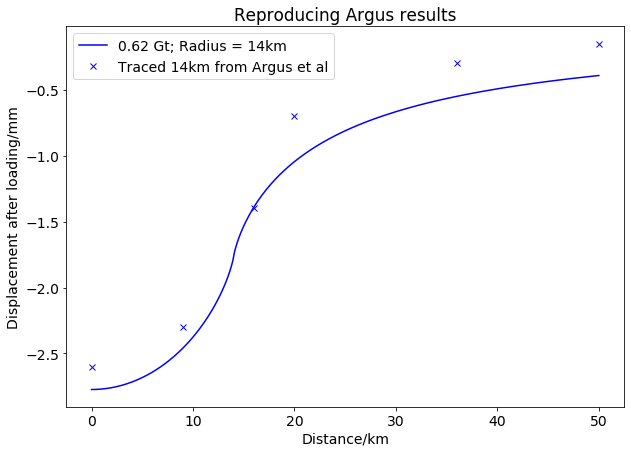

In [136]:
g = 9.81 # Seogi: gravity acceleration?
lamda = 25*10**9 # Lame parameter of granite
mu = 40*10**9 # Shear modulus of granite
M = np.pi * (14*10**3)**2 * 1 * 1000
alpha = 14*10**3
r_argus = np.linspace(0,50*10**3,num=1000)

delta_d = calc_deformation_disk(M,lamda,mu,alpha,r_argus)
delta_d_2d = calc_deformation_2Ddisk(M,lamda,mu,alpha,r_argus)

fig,ax = plt.subplots(1,1,figsize=(10,7))
plt.plot(
    r_argus/1000,delta_d*1000,color='blue',
    label="0.62 Gt; Radius = 14km"
) 
plt.plot(
    argus_traced_14_distance,argus_traced_14_disp,'x',
    color='blue',
    label="Traced 14km from Argus et al"
)

plt.xlabel('Distance/km')
plt.ylabel('Displacement after loading/mm')

plt.title("Reproducing Argus results")


plt.legend()
plt.show()

## Step2: Create SimPEG `Problem` class

In [141]:
from SimPEG.Problem import BaseProblem
from SimPEG.Survey import BaseSurvey
from SimPEG import Props, Maps

class SWEProblem(BaseProblem):
    
    mass, massMap, massDeriv = Props.Invertible(
        "Mass (kg)"
    )

    mu = Props.PhysicalProperty(
        "Shear modulus (??)",
        default=40.*10**9
    )
    
    alpha = Props.PhysicalProperty(
        "Disk radius (m)",
        default=14.*10**3
    )
    
    lamda = Props.PhysicalProperty(
        "Lame parameter (??)",
        default=25.*10**9
    )    
    
    _G = None
    cylinder_locations = None
    
    def __init__(self, mesh, **kwargs):
        BaseProblem.__init__(self, mesh, **kwargs)
        mapPair = Maps.IdentityMap  #: Type of mapping to pair with

    def fields(self, m):
        self.model = m
        return self.G.dot(self.massMap * m)

    def getJ(self, m, f=None):
        """
            Sensitivity matrix
        """

        if self.massMap is not None:
            dmudm = self.massMap.deriv(m)
            return self.G*dmudm
        else:
            return self.G

    @property
    def G(self):
        """
        Calculate G matrix to have a linear equation
        
        d = Gm
        
        """
        if getattr(self, '_G', None) is None:
            # assume a single disk at the moment
            # Todo: extend this for multiple cylinders?
            self._G = np.zeros((self.survey.nD, self.mesh.nC))            
            sigma=self.lamda+2*mu
            nabla=self.lamda+mu
            r = np.sqrt(((self.survey.rx_locations-self.cylinder_locations)**2).sum(axis=1))
            r_disk = r[r<=alpha]
            r_postdisk = r[r>=alpha]
            self._G[r<=alpha,0] =-g* (
                sigma/(np.pi**2 * mu * nabla * alpha) * 
                special.ellipe((r_disk/alpha)**2) 
            )  
            self._G[r>=alpha,0] = -g * (
                (sigma* r_postdisk / (np.pi**2 * mu * nabla * alpha**2)) * 
                (
                    special.ellipe((alpha/r_postdisk)**2) - 
                    (1 - (alpha/r_postdisk)**2) * special.ellipk((alpha/r_postdisk)**2)
                )
            )
        return self._G
    
    def Jvec(self, m, v, f=None):
        return self.G.dot(self.massMap.deriv(m) * v)

    def Jtvec(self, m, v, f=None):
        return self.massMap.deriv(m).T*self.G.T.dot(v)
    
class SWESurvey(BaseSurvey):
    
    rx_locations = None

    def __init__(self, **kwargs):
        BaseSurvey.__init__(self, **kwargs)
    
    def eval(self, f):
        return f

    @property
    def nD(self):
        return self.rx_locations.shape[0]

In [142]:
from SimPEG import Mesh

In [143]:
mesh = Mesh.TensorMesh([1,1,1])
cylinder_locations = np.array([0, 0, 0])
x = np.linspace(0,50*10**3,num=1000)
y = np.zeros_like(x)
z = np.zeros_like(x)

rx_locations = np.c_[x, y, z]
prob = SWEProblem(
    mesh, 
    massMap = Maps.IdentityMap(mesh),
    cylinder_locations=cylinder_locations,
    mu=np.array([mu]),
    alpha=np.array([alpha]),    
)
survey = SWESurvey(rx_locations=rx_locations)
prob.pair(survey)
model = np.array([M])
data = survey.dpred(model)

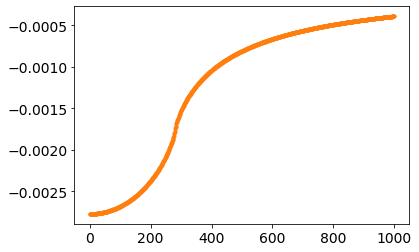

In [144]:
plt.plot(data)
plt.plot(defm_Argus1, '.')